Импорты библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch
from torch import nn, optim
import joblib

Загрузка тестового и тренировочного датасетов

In [62]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Предобработка данных (удаление пропущенных значений, удаление выбросов, преобразование признака chest (chest_bin) в целые числа [В условиях задания было указано, что боли в груди оцениваются по шкале от 1 до 4, обычно такие шкалы используют целочисленные значения, поэтому данные были приведены к целым числам])

In [63]:
# Удаление пропущенных значений
train_df = train_df.dropna()
test_df = test_df.dropna()

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    train_df = remove_outliers_iqr(train_df, col)

# Преобразуем в целые числа
train_df['chest'] = train_df['chest'].round().astype(int)
test_df['chest'] = test_df['chest'].round().astype(int)

# Округление и ограничение значений
train_df['chest'] = np.clip(train_df['chest'].round().astype(int), 1, 4)
test_df['chest'] = np.clip(test_df['chest'].round().astype(int), 1, 4)

# Проверка уникальных значений
print("Уникальные значения в 'chest' (train):", train_df['chest'].unique())
print("Уникальные значения в 'chest' (test):", test_df['chest'].unique())

Количество NaN в X_train: 0
Уникальные значения в 'chest' (train): [4 2 3]
Уникальные значения в 'chest' (test): [4 1 3 2]
Количество NaN в X_train: 0


Преобразование категориальных переменных в фиктивные переменные

In [64]:
categorical_cols = ['sex', 'chest', 'resting_electrocardiographic_results', 'slope', 'thal']
encoder = OneHotEncoder(sparse_output=False)

print("Количество NaN в X_train:", train_df['class'].isnull().sum().sum())
print("Колонки в train_df:", train_df.columns.tolist())
print("Колонки в test_df:", test_df.columns.tolist())

# Явно задаем возможные категории для каждого признака
categories = [
    [0, 1],  # sex
    [1, 2, 3, 4],  # chest_bin
    [0, 1, 2],  # resting_electrocardiographic_results
    [1, 2, 3],  # slope
    [3, 6, 7]  # thal
]

# Указываем handle_unknown='ignore' для обработки неизвестных категорий
encoder = OneHotEncoder(categories=categories, handle_unknown='ignore', sparse_output=False)

# Обучение на тренировочных данных
train_encoded = encoder.fit_transform(train_df[categorical_cols])
test_encoded = encoder.transform(test_df[categorical_cols])

# Преобразуем в DataFrame
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=train_df.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=test_df.index)

# Объединяем с числовыми признаками
train_df = pd.concat([train_df.drop(categorical_cols, axis=1), train_encoded_df], axis=1)
test_df = pd.concat([test_df.drop(categorical_cols, axis=1), test_encoded_df], axis=1)

Количество NaN в X_train: 0
Колонки в train_df: ['ID', 'age', 'sex', 'chest', 'resting_blood_pressure', 'serum_cholestoral', 'fasting_blood_sugar', 'resting_electrocardiographic_results', 'maximum_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak', 'slope', 'number_of_major_vessels', 'thal', 'class']
Колонки в test_df: ['ID', 'age', 'sex', 'chest', 'resting_blood_pressure', 'serum_cholestoral', 'fasting_blood_sugar', 'resting_electrocardiographic_results', 'maximum_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak', 'slope', 'number_of_major_vessels', 'thal']
Количество NaN в X_train: 0
Колонки в train_df: ['ID', 'age', 'resting_blood_pressure', 'serum_cholestoral', 'fasting_blood_sugar', 'maximum_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak', 'number_of_major_vessels', 'class', 'sex_0', 'sex_1', 'chest_1', 'chest_2', 'chest_3', 'chest_4', 'resting_electrocardiographic_results_0', 'resting_electrocardiographic_results_1', 'resting_electrocardiographic_resul

Корреляционный анализ

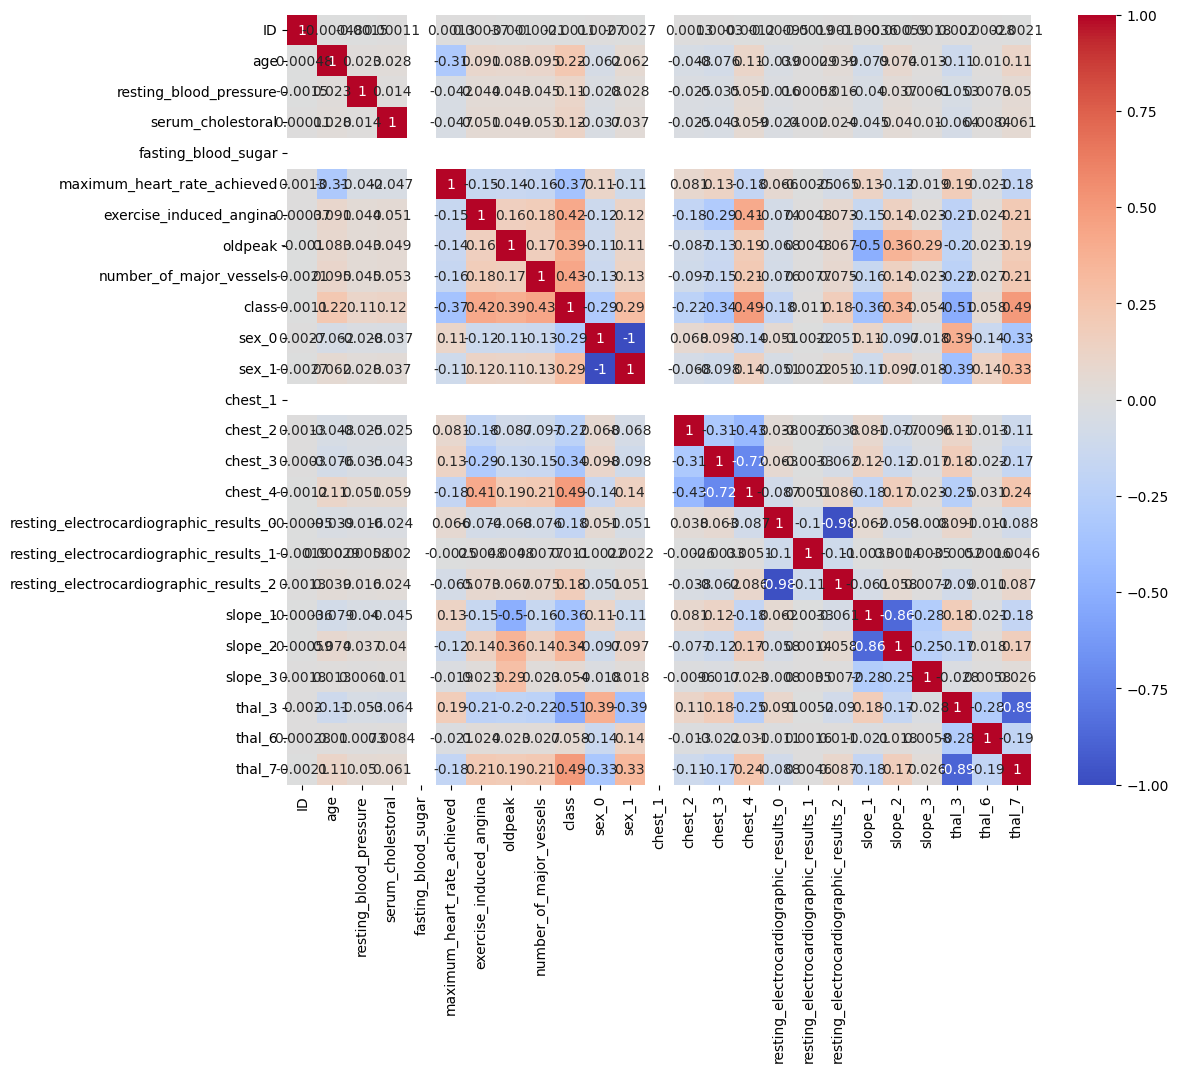

In [65]:
correlation_matrix = train_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Построение бокс-плотов

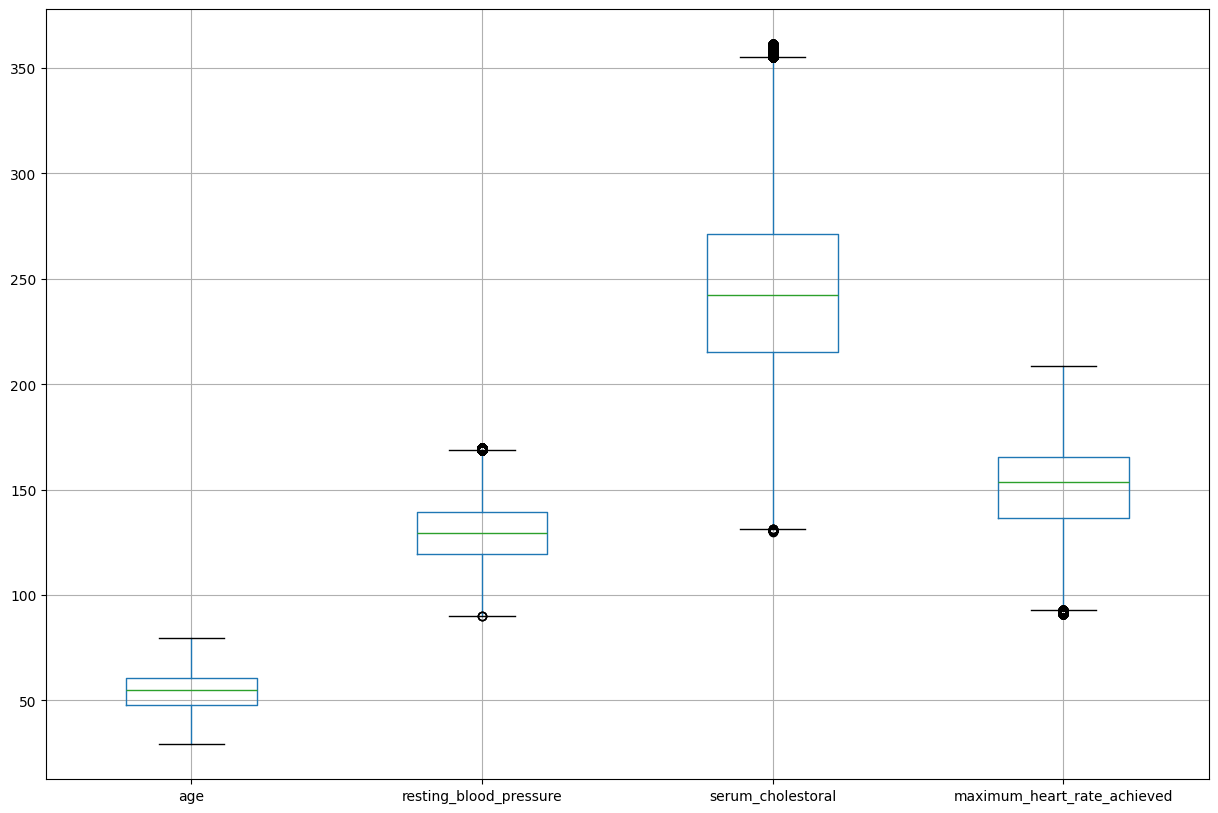

In [66]:
plt.figure(figsize=(15, 10))
train_df.boxplot(column=['age', 'resting_blood_pressure', 'serum_cholestoral', 'maximum_heart_rate_achieved'])
plt.show()

Разделение тренировочного датасета на тренировочный и валидационный (так как в тестовом отсуствует столбец 'class' и выполнить оценку по такому датасету не представляется возможным)

In [67]:
X_train = train_df.drop('class', axis=1)
y_train = train_df['class']

X_test = test_df.copy()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Обучение логистической регрессии

In [71]:
model_lr = LogisticRegression(max_iter=10000)
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_val)
print("Accuracy:", accuracy_score(y_val, pred_lr))

Количество NaN в X_train: 0
Количество NaN в X_val: 0
Accuracy: 0.8830711920529801


Случайный лес

In [72]:
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_val)
print("Accuracy:", accuracy_score(y_val, pred_rf))

Accuracy: 0.8922885888945492


Нейронная сеть

Epoch 1/50, Train Loss: 57.6526, Val Loss: 57.4349
Epoch 2/50, Train Loss: 57.6437, Val Loss: 57.4271
Epoch 3/50, Train Loss: 57.6312, Val Loss: 57.4212
Epoch 4/50, Train Loss: 57.6214, Val Loss: 57.4206
Epoch 5/50, Train Loss: 57.6153, Val Loss: 57.4203
Epoch 6/50, Train Loss: 57.6266, Val Loss: 57.4188
Epoch 7/50, Train Loss: 57.6219, Val Loss: 57.4145
Epoch 8/50, Train Loss: 57.6215, Val Loss: 57.4103
Epoch 9/50, Train Loss: 57.6167, Val Loss: 57.4086
Epoch 10/50, Train Loss: 57.6135, Val Loss: 57.4029
Epoch 11/50, Train Loss: 57.6123, Val Loss: 57.3971
Epoch 12/50, Train Loss: 57.6022, Val Loss: 57.3941
Epoch 13/50, Train Loss: 57.6050, Val Loss: 57.3910
Epoch 14/50, Train Loss: 57.5953, Val Loss: 57.3893
Epoch 15/50, Train Loss: 57.5893, Val Loss: 57.3876
Epoch 16/50, Train Loss: 57.5828, Val Loss: 57.3860
Epoch 17/50, Train Loss: 57.5816, Val Loss: 57.3831
Epoch 18/50, Train Loss: 57.5776, Val Loss: 57.3745
Epoch 19/50, Train Loss: 57.5761, Val Loss: 57.3714
Epoch 20/50, Train Lo

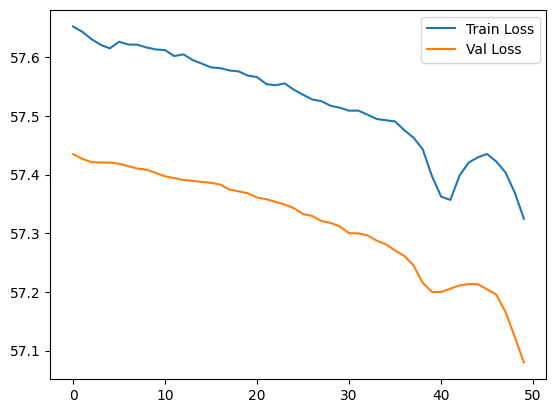

In [74]:
class HeartDiseaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(24, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model_nn = HeartDiseaseModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)

# Обучение
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Обучение
    model_nn.train()
    optimizer.zero_grad()
    outputs = model_nn(torch.tensor(X_train.values, dtype=torch.float32))
    loss = criterion(outputs.squeeze(), torch.tensor(y_train.values, dtype=torch.float32))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Валидация
    model_nn.eval()
    with torch.no_grad():
        val_outputs = model_nn(torch.tensor(X_val.values, dtype=torch.float32))
        val_loss = criterion(val_outputs.squeeze(), torch.tensor(y_val.values, dtype=torch.float32))
        val_losses.append(val_loss.item())

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Графики обучения
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

Тестирование моделей

In [78]:
pred_nn = (model_nn(torch.tensor(X_val.values, dtype=torch.float32)).detach().numpy() > 0.5).astype(int).flatten()

print("Logistic Regression Accuracy:", accuracy_score(y_val, pred_lr))
print("Random Forest Accuracy:", accuracy_score(y_val, pred_rf))
print("Neural Network Accuracy:", accuracy_score(y_val, pred_nn))

Logistic Regression Accuracy: 0.8830711920529801
Random Forest Accuracy: 0.8922885888945492
Neural Network Accuracy: 0.4258946765155374


Сохранение модели

In [79]:
# Сохранение модели
torch.save(model_nn.state_dict(), 'best_model.pth')

Скрипт инференса

In [ ]:
test_df = pd.read_csv('test.csv')

if 'ID' in test_df.columns:
    ids = test_df['ID']
else:
    ids = test_df.index

categorical_cols = ['sex', 'chest', 'resting_electrocardiographic_results', 'slope', 'thal']

encoder = joblib.load('encoder.pkl')

test_encoded = encoder.transform(test_df[categorical_cols])

test_encoded_df = pd.DataFrame(
    test_encoded,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=test_df.index
)

test_df = test_df.drop(categorical_cols, axis=1)

test_df = pd.concat([test_df, test_encoded_df], axis=1)

test_tensor = torch.tensor(test_df.values, dtype=torch.float32)

model = HeartDiseaseModel(input_size=24)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    outputs = model(test_tensor)
    predictions = (outputs.numpy() > 0.5).astype(int).flatten()

results = pd.DataFrame({
    'ID': ids,
    'Predicted_Class': predictions
})
results.to_csv('test_predictions.csv', index=False)

print("Предсказания сохранены в файл 'test_predictions.csv'")